# Phase 3 - Modeling

**Note 1: the following starting code only generates a single random train/test split when default_seed is used. You need to modify the code to generate 100 independent train/test splits with different seeds and report the average results on those independent splits along with standard deviation.**

**Note 2: You are completely free to use your own implementation.**

In [ ]:
# !pip install spline

In [ ]:
# Load general utilities
# ----------------------
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import datetime
import numpy as np
import pickle
import time
import seaborn as sns
import os

# Load sklearn utilities
# ----------------------
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score

from sklearn.calibration import calibration_curve

# Load classifiers
# ----------------
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

# Other Packages
# --------------
from scipy.stats import kendalltau
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import spline

# Load debugger, if required
#import pixiedust
pd.options.mode.chained_assignment = None #'warn'

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Define a function that, given a CVGridSearch object, finds the
# percentage difference between the best and worst scores
def find_score_variation(cv_model):
    all_scores = cv_model.cv_results_['mean_test_score']
    return( np.abs((max(all_scores) - min(all_scores))) * 100 / max(all_scores) )

    '''
    which_min_score = np.argmin(all_scores)
    
    all_perc_diff = []
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score - 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score + 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    return ( np.mean(all_perc_diff) )
    '''

# Define a function that checks, given a CVGridSearch object,
# whether the optimal parameters lie on the edge of the search
# grid
def find_opt_params_on_edge(cv_model):
    out = False
    
    for i in cv_model.param_grid:
        if cv_model.best_params_[i] in [ cv_model.param_grid[i][0], cv_model.param_grid[i][-1] ]:
            out = True
            break
            
    return out

## Define a default random seed and an output file

In [ ]:
default_seed = 1
output_file = "output_sample"

In [ ]:
# Create a function to print a line to our output file

def dump_to_output(key, value):
    with open(output_file, "a") as f:
        f.write(",".join([str(default_seed), key, str(value)]) + "\n")

# 3.1. Predictive Models of Default

## 1. Implementing Machine Learning Models after loading the data

## Load the data and engineer the features

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# base_path = '/content/gdrive/MyDrive/MLPS Case Study/Phase 3'

In [ ]:
# Read the data and features from the pickle file saved in CS-Phase 2
#data, discrete_features, continuous_features, ret_cols = pickle.load( open( base_path+"/clean_data.pickle", "rb" ) )
data, discrete_features, continuous_features, ret_cols = pickle.load( open( "clean_data.pickle", "rb" ) )

In [ ]:
## Create the outcome columns: True if loan_status is either Charged Off or Default, False otherwise
data["outcome"] = data['loan_status'].apply(lambda x: True if x=="Charged Off" or x=="Default" else False)

In [ ]:
# Create a feature for the length of a person's credit history at the time the loan is issued
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')

In [ ]:
# Randomly assign each row to a training and test set. We do this now because we will be fitting a variety of models on various time periods, and we would like every period to use the *same* training/test split
np.random.seed(default_seed)
## create the train column where the value is True if it is a train instance and False otherwise. Hint: use np.random.choice with 70% for training and 30% for testing
p=[0.3,0.7]
data['train'] = np.random.choice(len(p),len(data),p=p)

In [ ]:
data['train'].replace({1:True,0:False},inplace=True)

In [ ]:
data['train'].value_counts()

True     789787
False    338830
Name: train, dtype: int64

In [ ]:
# Create a matrix of features and outcomes, with dummies. Record the names of the dummies for later use
X_continuous = data[continuous_features].values

X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

y = data.outcome.values

train = data.train.values

## Prepare functions to fit and evaluate models

In [ ]:
def prepare_data(data_subset = np.array([True]*len(data)),
                    n_samples_train = 8500,
                    n_samples_test = 7000,
                    feature_subset = None,
                    date_range_train = (data.issue_d.min(), data.issue_d.max()),
                    date_range_test = (data.issue_d.min(), data.issue_d.max()),
                    random_state = default_seed):
    '''
    This function will prepare the data for classification or regression.
    It expects the following parameters:
      - data_subset: a numpy array with as many entries as rows in the
                     dataset. Each entry should be True if that row
                     should be used, or False if it should be ignored
      - n_samples_train: the total number of samples to be used for training.
                         Will trigger an error if this number is larger than
                         the number of rows available after all filters have
                         been applied
      - n_samples_test: as above for testing
      - feature_subect: A list containing the names of the features to be
                        used in the model. In None, all features in X are
                        used
      - date_range_train: a tuple containing two dates. All rows with loans
                          issued outside of these two dates will be ignored in
                          training
      - date_range_test: as above for testing
      - random_state: the random seed to use when selecting a subset of rows
      
    Note that this function assumes the data has a "Train" column, and will
    select all training rows from the rows with "True" in that column, and all
    the testing rows from those with a "False" in that column.
    
    This function returns a dictionary with the following entries
      - X_train: the matrix of training data
      - y_train: the array of training labels
      - train_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the train set
      - X_test: the matrix of testing data
      - y_test: the array of testing labels
      - test_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the test set
    '''
    
    np.random.seed(random_state)
        
    # Filter down the data to the required date range, and downsample
    # as required
    filter_train = ( train & (data.issue_d >= date_range_train[0]) &
                            (data.issue_d <= date_range_train[1]) & data_subset ).values
    filter_test = ( (train == False) & (data.issue_d >= date_range_test[0])
                            & (data.issue_d <= date_range_test[1]) & data_subset ).values


    filter_train[ np.random.choice( np.where(filter_train)[0], size = filter_train.sum()
                                                   - n_samples_train, replace = False ) ] = False
    filter_test[ np.random.choice( np.where(filter_test)[0], size = filter_test.sum()
                                                   - n_samples_test, replace = False ) ] = False
    
    # Prepare the training and test set
    X_train = X[ filter_train , :]
    X_test = X[ filter_test, :]
    if feature_subset != None:
        cols = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in feature_subset]
        X_train = X_train[ : , cols ]
        X_test = X_test[ : , cols ]
        
    y_train = y[ filter_train ]
    y_test = y[ filter_test ]
    
    # Scale the variables
    scaler = preprocessing.MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # return training and testing data
    out = {'X_train':X_train, 'y_train':y_train, 'train_set':filter_train, 
           'X_test':X_test, 'y_test':y_test, 'test_set':filter_test}
    
    return out

In [ ]:
def fit_classification(model, data_dict,
                          cv_parameters = {},
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True):
    '''
    This function will fit a classification model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    If the model provided does not have a predict_proba function, we will
    simply print accuracy diagnostics and return.
    
    If the model provided does have a predict_proba function, we first
    figure out the optimal threshold that maximizes the accuracy and
    print out accuracy diagnostics. We then print an ROC curve, sensitivity/
    specificity curve, and calibration curve.
    
    This function returns a dictionary with the following entries
      - model: the best fitted model
      - y_pred: predictions for the test set
      - y_pred_probs: probability predictions for the test set, if the model
                      supports them
      - y_pred_score: prediction scores for the test set, if the model does not 
                      output probabilities.
    '''
        
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    
    X_test = data_dict['X_test']
    y_test = data_dict['y_test']
    
    filter_train = data_dict['train_set']    
  
    # --------------------------
    #   Step 2 - Fit the model
    # --------------------------

    cv_model = GridSearchCV(model, cv_parameters, scoring='f1_weighted')
    
    start_time = time.time()
    cv_model.fit(X_train, y_train)
    end_time = time.time()
    
    best_model = cv_model.best_estimator_
    
    if print_to_screen:

        if model_name != None:
            print("=========================================================")
            print("  Model: " + model_name)
            print("=========================================================")

        print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
        print("Optimal parameters:")
        print(cv_model.best_params_)
        print("")
    
    # -------------------------------
    #   Step 3 - Evaluate the model
    # -------------------------------
    
    # If possible, make probability predictions
    try:
        y_pred_probs = best_model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
        
        probs_predicted = True
    except:
        probs_predicted = False
    
    # Make predictions; if we were able to find probabilities, use
    # the threshold that maximizes the accuracy in the training set.
    # If not, just use the learner's predict function
    if probs_predicted:
        y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)
        
        true_pos_train = tpr_train*(y_train.sum())
        true_neg_train = (1 - fpr_train) *(1-y_train).sum()
        
        best_threshold_index = np.argmax(true_pos_train + true_neg_train)
        best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]
        
        if print_to_screen:
            print("Accuracy-maximizing threshold was: " + str(best_threshold))
        
        y_pred = (y_pred_probs > best_threshold)
    else:
        y_pred = best_model.predict(X_test)
    
    if print_to_screen:
        print("Accuracy: ", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred, target_names =['No default', 'Default'], digits = 4))

    if print_to_screen:
        if probs_predicted:        
            plt.figure(figsize = (13, 4.5))
            plt.subplot(2, 2, 1)

            plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
            plt.plot(fpr, tpr, 'b')
            plt.plot([0,1],[0,1],'r--')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')

            plt.subplot(2, 2, 3)

            plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
            plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
            plt.legend(loc = 'lower right')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.xlabel('Threshold')

            plt.subplot(2, 2, 2)

            fp_0, mpv_0 = calibration_curve(y_test, y_pred_probs, n_bins = 10)
            plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
            plt.plot(mpv_0, fp_0, 's-')
            plt.ylabel('Fraction of Positives')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.legend(loc ='upper left')
            
            plt.subplot(2, 2, 4)
            plt.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)
            plt.xlim([0,1]); plt.ylim([0,20000])
            plt.xlabel('Mean Predicted Probability')
            plt.ylabel('Count')
            
            #plt.tight_layout()
            plt.show()
        
    # Additional Score Check
    if probs_predicted:
        y_train_score = y_train_pred_probs
    else:
        y_train_score = best_model.decision_function(X_train)
        
    tau, p_value = kendalltau(y_train_score, data.grade[filter_train])
    if print_to_screen:
        print("")
        print("Similarity to LC grade ranking: ", tau)
    
    if probs_predicted:
        brier_score = brier_score_loss(y_test, y_pred_probs)
        if print_to_screen:
            print("Brier score:", brier_score)
    
    # Return the model predictions, and the
    # test set
    # -------------------------------------
    out = {'model':best_model, 'y_pred_labels':y_pred}
    
    if probs_predicted:
        out.update({'y_pred_probs':y_pred_probs})
    else:
        y_pred_score = best_model.decision_function(X_test)
        out.update({'y_pred_score':y_pred_score})
        
    # Output results to file
    # ----------------------
    if probs_predicted and output_to_file:
        # Check whether any of the CV parameters are on the edge of
        # the search space
        opt_params_on_edge = find_opt_params_on_edge(cv_model)
        dump_to_output(model_name + "::search_on_edge", opt_params_on_edge)
        if print_to_screen:
            print("Were parameters on edge? : " + str(opt_params_on_edge))
        
        # Find out how different the scores are for the different values
        # tested for by cross-validation. If they're not too different, then
        # even if the parameters are off the edge of the search grid, we should
        # be ok
        score_variation = find_score_variation(cv_model)
        dump_to_output(model_name + "::score_variation", score_variation)
        if print_to_screen:
            print("Score variations around CV search grid : " + str(score_variation))
        
        # Print out all the scores
        dump_to_output(model_name + "::all_cv_scores", str(cv_model.cv_results_['mean_test_score']))
        if print_to_screen:
            print( str(cv_model.cv_results_['mean_test_score']) )
        
        # Dump the AUC to file
        dump_to_output(model_name + "::roc_auc", roc_auc_score(y_test, y_pred_probs) )
        out.update({'accuracy_score': accuracy_score(y_test, y_pred),
                    'roc_auc_score': roc_auc_score(y_test, y_pred_probs),
                    'precision_score':precision_score(y_test, y_pred, average='weighted'),
                    'recall_score': recall_score(y_test, y_pred, average='weighted'),
                    'f1_score': f1_score(y_test, y_pred, average='weighted')})
                
    return out

## Train and Test different machine learning classification models

The machine learning models listed in the following are just our suggestions. You are free to try any other models that you would like to experiment with.

In [ ]:
## define your set of features to use in different models
your_features = continuous_features+discrete_features
# prepare the train, test data for training models
data_dict = prepare_data(feature_subset = your_features)

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in your_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

### Naive Bayes

  Model: Gaussian NB
Fit time: 4.84 seconds
Optimal parameters:
{'var_smoothing': 0.1}

Accuracy-maximizing threshold was: 0.99740362390606
Accuracy:  0.7907
              precision    recall  f1-score   support

  No default     0.7927    0.9955    0.8826     15810
     Default     0.5137    0.0179    0.0346      4190

    accuracy                         0.7907     20000
   macro avg     0.6532    0.5067    0.4586     20000
weighted avg     0.7343    0.7907    0.7050     20000



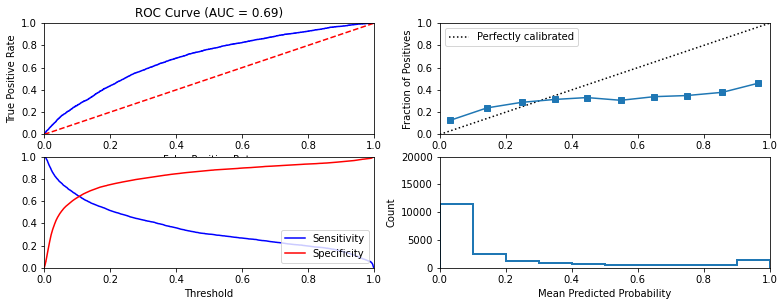


Similarity to LC grade ranking:  0.7057037819343319
Brier score: 0.19065655367162096
Were parameters on edge? : False
Score variations around CV search grid : 6.33923458255524
[0.73915755 0.7418959  0.75059286 0.70301102 0.70301102 0.70301102
 0.70301102]


In [ ]:
## Train and test a naive bayes classifier

gnb = GaussianNB()
gnb = fit_classification(gnb, data_dict,
                         random_state = default_seed,
                         cv_parameters= {"var_smoothing":[0.001,0.01,0.1,1,10,100,1000]},
                         model_name="Gaussian NB",
                         )

### $l_1$ regularized logistic regression

  Model: L1 regularized logistic regression
Fit time: 209.09 seconds
Optimal parameters:
{'C': 10}

Accuracy-maximizing threshold was: 0.5055214309567968
Accuracy:  0.79215
              precision    recall  f1-score   support

  No default     0.7981    0.9866    0.8824     15810
     Default     0.5361    0.0585    0.1054      4190

    accuracy                         0.7922     20000
   macro avg     0.6671    0.5225    0.4939     20000
weighted avg     0.7432    0.7922    0.7196     20000



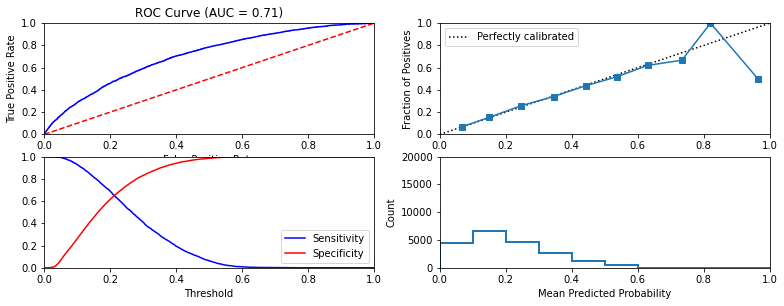


Similarity to LC grade ranking:  0.7383373721958902
Brier score: 0.150803758255829
Were parameters on edge? : False
Score variations around CV search grid : 3.4550120866806227
[0.72812529 0.7268175  0.72816936 0.71936821 0.70301102]


In [ ]:
## Train and test a l_1 regularized logistic regression classifier

l1_logistic = LogisticRegression(penalty='l1', solver='liblinear')
cv_parameters = {'C':[100, 1, 10, 0.1, .001]}

l1_logistic = fit_classification(l1_logistic,data_dict,
                                cv_parameters=cv_parameters,
                                model_name="L1 regularized logistic regression",
                                random_state=default_seed)

### $l_2$ regularized logistic regression

  Model: L2 regularized logistic regression
Fit time: 24.3 seconds
Optimal parameters:
{'C': 1000}

Accuracy-maximizing threshold was: 0.4976259114664914
Accuracy:  0.7927
              precision    recall  f1-score   support

  No default     0.7990    0.9857    0.8826     15810
     Default     0.5444    0.0644    0.1152      4190

    accuracy                         0.7927     20000
   macro avg     0.6717    0.5251    0.4989     20000
weighted avg     0.7457    0.7927    0.7218     20000



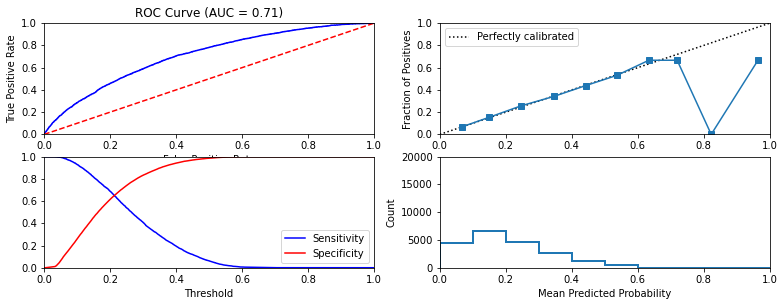


Similarity to LC grade ranking:  0.7407559292232002
Brier score: 0.15084459770811212
Were parameters on edge? : True
Score variations around CV search grid : 3.4458484074472646
[0.72810025 0.72720161 0.72710482 0.7247038  0.7212942  0.70301102]


In [ ]:
## Train and test a l_2 regularized logistic regression classifier

l2_logistic = LogisticRegression(penalty='l2', solver='lbfgs')
cv_parameters = {'C':[1000, 100, 10, 1, .1, .001]}

l2_logistic = fit_classification(l2_logistic,data_dict,
                                cv_parameters=cv_parameters,
                                model_name="L2 regularized logistic regression",
                                random_state=default_seed)

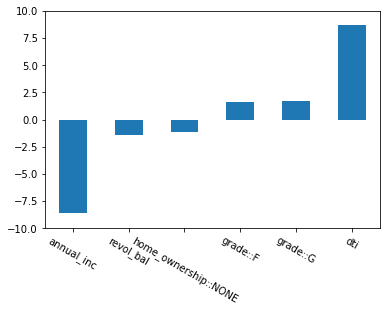

In [ ]:
## plot top 3 features with the most positive (and negative) weights 
top_and_bottom_idx = list(np.argsort(l2_logistic['model'].coef_)[0,:3]) + list(np.argsort(l2_logistic['model'].coef_)[0,-3:])
bplot = pd.Series(l2_logistic['model'].coef_[0,top_and_bottom_idx])
xticks = selected_features[top_and_bottom_idx]
p1 = bplot.plot(kind='bar',rot=-30,ylim=(-10,10))
p1.set_xticklabels(xticks)
plt.show()

### Decision tree

  Model: Decision Tree
Fit time: 876.87 seconds
Optimal parameters:
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 16, 'min_samples_split': 2}

Accuracy-maximizing threshold was: 0.5080645161290323
Accuracy:  0.7768
              precision    recall  f1-score   support

  No default     0.8015    0.9538    0.8711     15810
     Default     0.3845    0.1088    0.1696      4190

    accuracy                         0.7768     20000
   macro avg     0.5930    0.5313    0.5204     20000
weighted avg     0.7142    0.7768    0.7241     20000



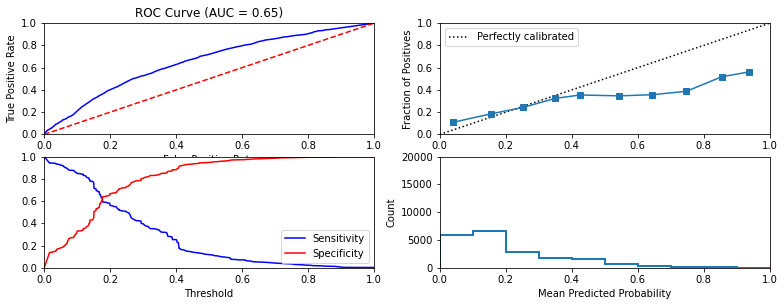


Similarity to LC grade ranking:  0.5242772404397864
Brier score: 0.16466955631168712
Were parameters on edge? : True
Score variations around CV search grid : 5.013262652435003
[0.70301102 0.70301102 0.70301102 0.70301102 0.70301102 0.70301102
 0.70301102 0.70301102 0.70301102 0.70301102 0.70301102 0.70301102
 0.70301102 0.70301102 0.70301102 0.70301102 0.70301102 0.70301102
 0.70301102 0.70301102 0.72152193 0.72149274 0.72136767 0.72115273
 0.72303434 0.72066365 0.72098121 0.72114777 0.72004396 0.72288386
 0.72352195 0.72359229 0.72357559 0.72352758 0.72630912 0.72489043
 0.72453465 0.72471082 0.72506392 0.72469166 0.702956   0.70316271
 0.70683497 0.71036922 0.71930206 0.70550668 0.70509531 0.70443847
 0.70860782 0.71794273 0.71379884 0.71442551 0.71414988 0.71427503
 0.72167168 0.72518551 0.72609099 0.7256002  0.7254963  0.72508093
 0.70546927 0.70437716 0.70411259 0.71031842 0.71937239 0.70431441
 0.70578272 0.7060502  0.70804884 0.71794346 0.71366497 0.71321535
 0.71425572 0.71424

In [ ]:
## Train and test a decision tree classifier
decision_tree = DecisionTreeClassifier()
cv_parameters = {'criterion':['gini','entropy'], 'max_depth':[2, 10, 100, 1000, 10000], 
          'min_samples_leaf':[2,4,8,16], 'min_samples_split':[2,4,8,16,32]}

decision_tree = fit_classification(decision_tree, data_dict, cv_parameters, 
                                   random_state=default_seed, 
                                   model_name = 'Decision Tree')

### Random forest

  Model: Random Forest
Fit time: 877.22 seconds
Optimal parameters:
{'bootstrap': True, 'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 2, 'n_jobs': -1, 'oob_score': True}

Accuracy-maximizing threshold was: 0.4311576354679803
Accuracy:  0.78475
              precision    recall  f1-score   support

  No default     0.8001    0.9701    0.8769     15810
     Default     0.4306    0.0852    0.1423      4190

    accuracy                         0.7847     20000
   macro avg     0.6154    0.5277    0.5096     20000
weighted avg     0.7227    0.7847    0.7230     20000



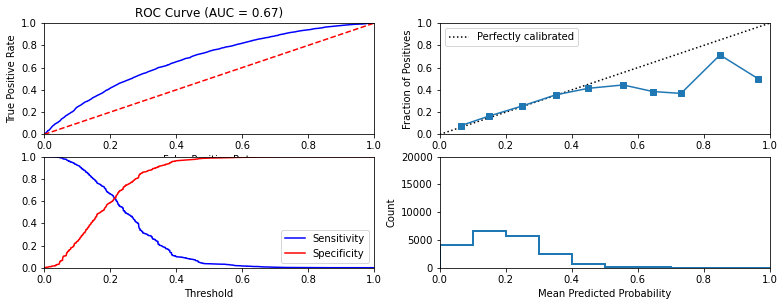


Similarity to LC grade ranking:  0.621642820429741
Brier score: 0.15615827217566194
Were parameters on edge? : True
Score variations around CV search grid : 2.737786766936706
[0.70301102 0.70301102 0.70301102 0.70301102 0.70301102 0.70301102
 0.70301102 0.70301102 0.70301102 0.70301102 0.70301102 0.70301102
 0.70301102 0.70301102 0.70301102 0.70301102 0.70301102 0.70301102
 0.70301102 0.70301102 0.70301102 0.70535708 0.70299457 0.70301102
 0.70301102 0.70301102 0.70301102 0.70301102 0.70684264 0.7030907
 0.70301102 0.70301102 0.70301102 0.70301102 0.70301102 0.7036243
 0.70301102 0.70301102 0.70301102 0.70301102 0.70301102 0.70301102
 0.70975221 0.70572979 0.70425533 0.70391524 0.70389894 0.70359807
 0.70369441 0.71427024 0.70491412 0.70365716 0.70408724 0.70339284
 0.70329666 0.70323354 0.70873131 0.70334232 0.70321699 0.70301102
 0.70301102 0.70301102 0.70301102 0.71812296 0.7123132  0.71067809
 0.70991007 0.70886713 0.70781939 0.7087256  0.72249113 0.71140874
 0.71157885 0.70978368

In [ ]:
## Train and test a random forest classifier
random_forest = RandomForestClassifier()
cv_parameters = {'criterion' : ['gini', 'entropy'], 'max_depth':[2,4,6,8], 'n_estimators':[2, 10, 20, 50, 100, 250, 500], 
                 'max_features':['auto', 'sqrt', 'log2'], 'n_jobs':[-1],
                 'bootstrap':[True], 'oob_score': [True]}

random_forest = fit_classification(random_forest, data_dict, cv_parameters, 
                                   random_state=default_seed,
                                   model_name = 'Random Forest')

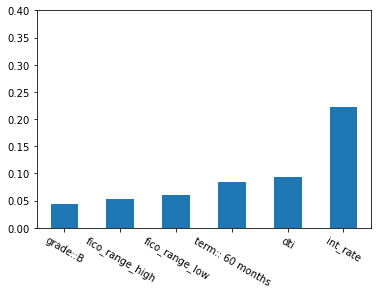

In [ ]:
## Plot top 6 most significant features
top_idx = list(np.argsort(random_forest['model'].feature_importances_)[-6:]) 
bplot = pd.Series(random_forest['model'].feature_importances_[top_idx])
xticks = selected_features[top_idx]
p2 = bplot.plot(kind='bar',rot=-30,ylim=(0,0.4))
p2.set_xticklabels(xticks)
plt.show()

### Multi-layer perceptron

  Model: Multi-Layer Perceptron
Fit time: 156.04 seconds
Optimal parameters:
{'activation': 'relu', 'alpha': 1e-05, 'hidden_layer_sizes': (32, 16), 'learning_rate': 'constant', 'solver': 'adam'}

Accuracy-maximizing threshold was: 0.4740075342845241
Accuracy:  0.77705
              precision    recall  f1-score   support

  No default     0.8092    0.9395    0.8695     15810
     Default     0.4181    0.1640    0.2356      4190

    accuracy                         0.7771     20000
   macro avg     0.6137    0.5517    0.5525     20000
weighted avg     0.7273    0.7771    0.7367     20000



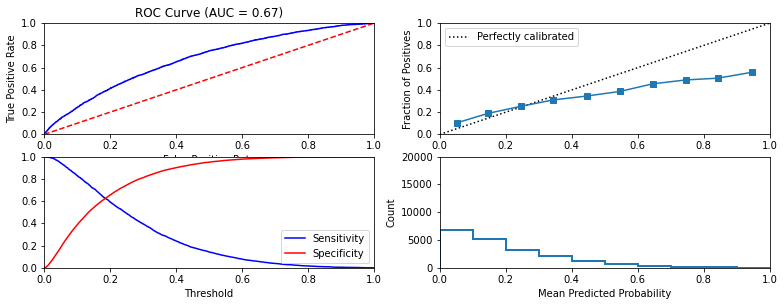


Similarity to LC grade ranking:  0.5496378209589372
Brier score: 0.16027327097989877
Were parameters on edge? : True
Score variations around CV search grid : 0.0
[0.73930411]


In [ ]:
## Train and test a multi-layer perceptron classifier

mlp = MLPClassifier()
cv_parameters = {'solver':['lbfgs','sgd', 'adam'], 'alpha':[1e-5,1e-4,1e-3],
                 'activation':['identity', 'logistic', 'tanh', 'relu'],
                 'hidden_layer_sizes':[(32,16), (16, 8), (8,8)],
                 'learning_rate':['constant', 'adaptive']}

                 
mlp = fit_classification(mlp, data_dict, cv_parameters, 
                        random_state=default_seed, 
                        model_name = 'Multi-Layer Perceptron')

## 3. Assessing whether the predictive power of your models came simply from LendingClub’s own predictors

## i) and ii) Train and Test logistic regression model with features derived by LendingClub

  Model: l1-regularized log. regression
Fit time: 0.64 seconds
Optimal parameters:
{'C': 10}

Accuracy-maximizing threshold was: 1
Accuracy:  0.7905
              precision    recall  f1-score   support

  No default     0.7905    1.0000    0.8830     15810
     Default     0.0000    0.0000    0.0000      4190

    accuracy                         0.7905     20000
   macro avg     0.3952    0.5000    0.4415     20000
weighted avg     0.6249    0.7905    0.6980     20000



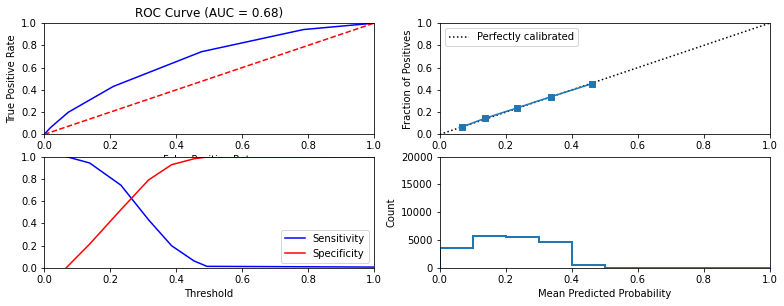


Similarity to LC grade ranking:  1.0
Brier score: 0.1545798502351803
Were parameters on edge? : True
Score variations around CV search grid : 0.21267716286627675
[0.70450935 0.70316232 0.70301102 0.70301102]


In [ ]:
## Find a lendingClub-defined feature and train a l1-regularized logistic regression model on data with only that feature
a_lendingclub_feature = ['grade']

data_dict = prepare_data(feature_subset = a_lendingclub_feature)
lc1_only_logistic = LogisticRegression(penalty='l1', solver='liblinear')
cv_parameters = {'C':[10, 1, .1, .001]}
lc1_only_logistic = fit_classification(lc1_only_logistic,data_dict,
                                        cv_parameters=cv_parameters,
                                        model_name="l1-regularized log. regression",
                                        random_state=default_seed)

  Model: l2-regularized log. regression
Fit time: 0.66 seconds
Optimal parameters:
{'C': 10}

Accuracy-maximizing threshold was: 1
Accuracy:  0.7905
              precision    recall  f1-score   support

  No default     0.7905    1.0000    0.8830     15810
     Default     0.0000    0.0000    0.0000      4190

    accuracy                         0.7905     20000
   macro avg     0.3952    0.5000    0.4415     20000
weighted avg     0.6249    0.7905    0.6980     20000



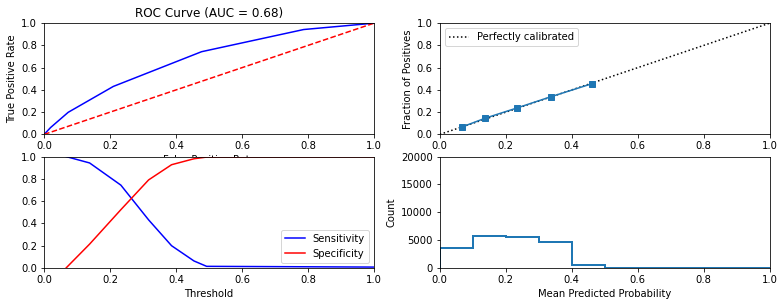


Similarity to LC grade ranking:  1.0
Brier score: 0.15457955166508439
Were parameters on edge? : True
Score variations around CV search grid : 0.21267716286627675
[0.70450935 0.70301102 0.70301102 0.70301102]


In [ ]:
## train a l2-regularized logistic regression model on data with only that feature
lc2_only_logistic =  LogisticRegression(penalty='l2', solver='lbfgs')
cv_parameters = {'C':[10, 1, .1, .001]}
lc2_only_logistic = fit_classification(lc2_only_logistic,data_dict,
                                        cv_parameters=cv_parameters,
                                        model_name="l2-regularized log. regression",
                                        random_state=default_seed)

## iii) Train and test all the models you have tried previously after removing features derived by LendingClub 

In [ ]:
features_to_drop=['grade','int_rate', 'verification_status']
your_features_dropped= [i for i in your_features if i not in features_to_drop]
data_dict = prepare_data(feature_subset = your_features_dropped)

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in your_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

  Model: Gaussian NB without LC features
Fit time: 1.38 seconds
Optimal parameters:
{'var_smoothing': 0.1}

Accuracy-maximizing threshold was: 0.7968136669216527
Accuracy:  0.79075
              precision    recall  f1-score   support

  No default     0.7917    0.9978    0.8829     15810
     Default     0.5333    0.0095    0.0188      4190

    accuracy                         0.7907     20000
   macro avg     0.6625    0.5037    0.4508     20000
weighted avg     0.7376    0.7907    0.7019     20000



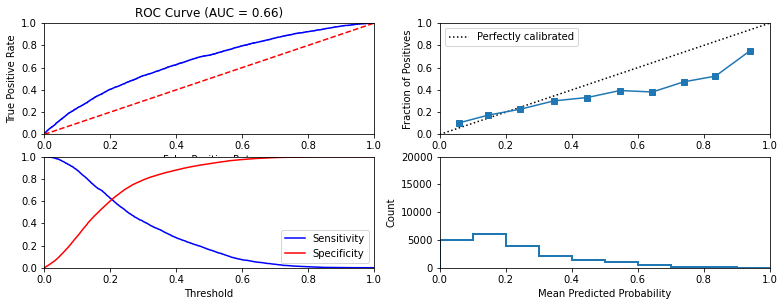


Similarity to LC grade ranking:  0.40375268216353616
Brier score: 0.1623309097583894
Were parameters on edge? : False
Score variations around CV search grid : 5.237817843344779
[0.71376393 0.73126564 0.74186875 0.70301102 0.70301102 0.70301102
 0.70301102]


In [ ]:
## Train and test a naive bayes classifier

gnb = GaussianNB()
gnb = fit_classification(gnb, data_dict,
                         random_state = default_seed, output_to_file = True,
                         cv_parameters = {"var_smoothing":[0.001,0.01,0.1,1,10,100,1000]},
                         model_name="Gaussian NB without LC features",
                         )

  Model: L1 regularized logistic regression without LC features
Fit time: 49.18 seconds
Optimal parameters:
{'C': 100}

Accuracy-maximizing threshold was: 0.5452806385071289
Accuracy:  0.7913
              precision    recall  f1-score   support

  No default     0.7935    0.9949    0.8829     15810
     Default     0.5455    0.0229    0.0440      4190

    accuracy                         0.7913     20000
   macro avg     0.6695    0.5089    0.4634     20000
weighted avg     0.7415    0.7913    0.7071     20000



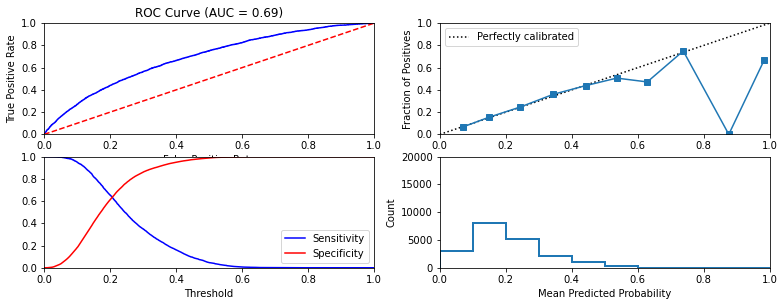


Similarity to LC grade ranking:  0.46966198425479955
Brier score: 0.1533608456417523
Were parameters on edge? : True
Score variations around CV search grid : 2.599829320520592
[0.72177596 0.72047721 0.72163942 0.71285813 0.70301102]


In [ ]:
## Train and test a l_1 regularized logistic regression classifier

l1_logistic = LogisticRegression(penalty='l1', solver='liblinear')
cv_parameters = {'C':[100, 1, 10, 0.1, .001]}

l1_logistic = fit_classification(l1_logistic,data_dict,
                                cv_parameters=cv_parameters, output_to_file = True,
                                model_name="L1 regularized logistic regression without LC features",
                                random_state=default_seed)

  Model: L2 regularized logistic regression without LC features
Fit time: 9.82 seconds
Optimal parameters:
{'C': 1000}

Accuracy-maximizing threshold was: 0.4426608329991706
Accuracy:  0.7884
              precision    recall  f1-score   support

  No default     0.8030    0.9705    0.8788     15810
     Default     0.4765    0.1014    0.1673      4190

    accuracy                         0.7884     20000
   macro avg     0.6397    0.5359    0.5230     20000
weighted avg     0.7346    0.7884    0.7297     20000



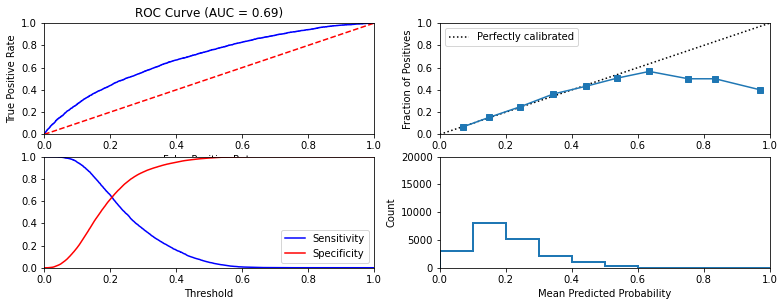


Similarity to LC grade ranking:  0.4718376301226106
Brier score: 0.1533177605975477
Were parameters on edge? : True
Score variations around CV search grid : 2.5800310697654303
[0.72162928 0.72154922 0.72085673 0.71774161 0.71471175 0.70301102]


In [ ]:
## Train and test a l_2 regularized logistic regression classifier

l2_logistic = LogisticRegression(penalty='l2', solver='lbfgs')
cv_parameters = {'C':[1000, 100, 10, 1, .1, .001]}

l2_logistic = fit_classification(l2_logistic,data_dict,
                                cv_parameters=cv_parameters, output_to_file = True,
                                model_name="L2 regularized logistic regression without LC features",
                                random_state=default_seed)

  Model: Decision Tree without LC features
Fit time: 240.89 seconds
Optimal parameters:
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 32}

Accuracy-maximizing threshold was: 0.5212765957446809
Accuracy:  0.7774
              precision    recall  f1-score   support

  No default     0.7993    0.9592    0.8720     15810
     Default     0.3726    0.0914    0.1468      4190

    accuracy                         0.7774     20000
   macro avg     0.5860    0.5253    0.5094     20000
weighted avg     0.7099    0.7774    0.7201     20000



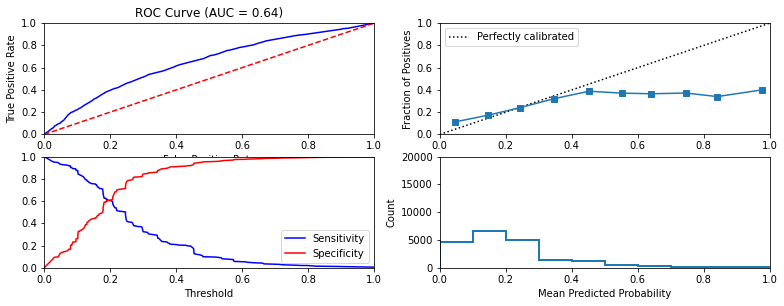


Similarity to LC grade ranking:  0.3646986795527142
Brier score: 0.16596865505521577
Were parameters on edge? : True
Score variations around CV search grid : 4.438808304165605
[0.70301102 0.70301102 0.70301102 0.70301102 0.70301102 0.70301102
 0.70301102 0.70301102 0.70301102 0.70301102 0.70301102 0.70301102
 0.70301102 0.70301102 0.70301102 0.70301102 0.70301102 0.70301102
 0.70301102 0.70301102 0.72874823 0.72903783 0.72941972 0.72908364
 0.73055706 0.72851045 0.72893754 0.72900789 0.72873526 0.7309687
 0.72945447 0.72936759 0.73014222 0.72995473 0.73224874 0.73054544
 0.73050791 0.73067492 0.73028949 0.73072747 0.70318186 0.7030283
 0.70353881 0.711446   0.72479385 0.71188976 0.71135714 0.71174222
 0.71307837 0.72610726 0.71956321 0.71972006 0.71867745 0.71903348
 0.72904198 0.72896971 0.72877552 0.7287637  0.72874841 0.72874443
 0.7029586  0.70429371 0.7043284  0.71186993 0.72456073 0.71104128
 0.71245974 0.71084403 0.71307506 0.72624556 0.71900833 0.71906732
 0.7189485  0.7196937

In [ ]:
## Train and test a decision tree classifier
decision_tree = DecisionTreeClassifier()
cv_parameters = {'criterion':['gini','entropy'], 'max_depth':[2, 10, 100, 1000, 10000], 
          'min_samples_leaf':[2,4,8,16], 'min_samples_split':[2,4,8,16,32]}

decision_tree = fit_classification(decision_tree, data_dict, cv_parameters, 
                                   random_state=default_seed, output_to_file = True,
                                   model_name = 'Decision Tree without LC features')

  Model: Random Forest without LC features
Fit time: 988.13 seconds
Optimal parameters:
{'bootstrap': True, 'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 2, 'n_jobs': -1, 'oob_score': True}

Accuracy-maximizing threshold was: 0.47316207184628234
Accuracy:  0.7804
              precision    recall  f1-score   support

  No default     0.7959    0.9713    0.8749     15810
     Default     0.3565    0.0599    0.1026      4190

    accuracy                         0.7804     20000
   macro avg     0.5762    0.5156    0.4887     20000
weighted avg     0.7038    0.7804    0.7131     20000



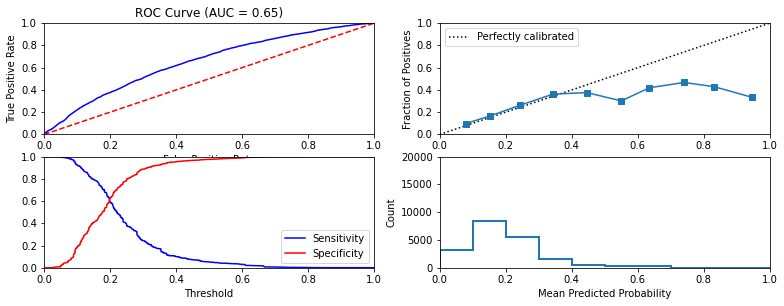


Similarity to LC grade ranking:  0.40440540493716254
Brier score: 0.16018154250746627
Were parameters on edge? : True
Score variations around CV search grid : 2.0763907571263993
[0.70301102 0.70301102 0.70301102 0.70301102 0.70301102 0.70301102
 0.70301102 0.70301102 0.70301102 0.70301102 0.70301102 0.70301102
 0.70301102 0.70301102 0.70309069 0.70301102 0.70301102 0.70301102
 0.70301102 0.70301102 0.70301102 0.70345285 0.70301102 0.70301102
 0.70301102 0.70301102 0.70301102 0.70301102 0.70486109 0.70301102
 0.70301102 0.70301102 0.70301102 0.70301102 0.70301102 0.70381474
 0.70301102 0.70301102 0.70301102 0.70301102 0.70301102 0.70301102
 0.71361539 0.70402947 0.70325004 0.70299457 0.7030907  0.70301102
 0.70301102 0.70745558 0.70416016 0.70335935 0.70317037 0.70301102
 0.7030907  0.70301102 0.70679552 0.7030907  0.70301102 0.70301102
 0.70301102 0.70301102 0.70301102 0.71636176 0.71105339 0.70673591
 0.70582744 0.70521734 0.70636005 0.70584955 0.7178842  0.70948748
 0.70798411 0.707

In [ ]:
## Train and test a random forest classifier
random_forest = RandomForestClassifier()
cv_parameters = {'criterion' : ['gini', 'entropy'], 'max_depth':[2,4,6,8], 'n_estimators':[2, 10, 20, 50, 100, 250, 500], 
                 'max_features':['auto', 'sqrt', 'log2'], 'n_jobs':[-1],
                 'bootstrap':[True], 'oob_score': [True]}

random_forest = fit_classification(random_forest, data_dict, cv_parameters, 
                                   random_state=default_seed, output_to_file = True,
                                   model_name = 'Random Forest without LC features')

  Model: Multi-Layer Perceptron Classifier without LC features
Fit time: 3379.06 seconds
Optimal parameters:
{'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (16, 8), 'learning_rate': 'constant', 'solver': 'lbfgs'}

Accuracy-maximizing threshold was: 0.4827960923544317
Accuracy:  0.7901
              precision    recall  f1-score   support

  No default     0.8009    0.9775    0.8804     15810
     Default     0.4943    0.0831    0.1422      4190

    accuracy                         0.7901     20000
   macro avg     0.6476    0.5303    0.5113     20000
weighted avg     0.7367    0.7901    0.7258     20000



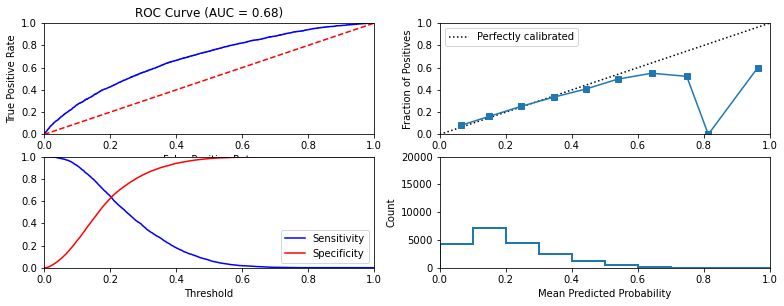


Similarity to LC grade ranking:  0.44276963568039374
Brier score: 0.15431902344319243
Were parameters on edge? : True
Score variations around CV search grid : 4.165775983943739
[0.72163189 0.71345331 0.71857328 0.72193979 0.71418716 0.72220093
 0.72191526 0.7123414  0.72115697 0.72158447 0.71354878 0.71839268
 0.72168042 0.71305982 0.71946183 0.72153572 0.71474065 0.71969304
 0.72180052 0.71296839 0.72021388 0.72217017 0.71253576 0.71853153
 0.72149849 0.71341148 0.72113417 0.72173025 0.7140929  0.71898096
 0.72211695 0.71388613 0.71932122 0.72175159 0.71504751 0.71950154
 0.72687986 0.70301102 0.70649932 0.7285897  0.70301102 0.71039575
 0.72559233 0.70301102 0.70519092 0.72824251 0.70301102 0.70513179
 0.72934961 0.70301102 0.70656341 0.72770306 0.70301102 0.70885126
 0.7266603  0.70301102 0.70464322 0.72654626 0.70301102 0.70486738
 0.72753737 0.70301102 0.70613541 0.72857928 0.70301102 0.70578682
 0.72753782 0.70301102 0.70476995 0.72444397 0.70301102 0.70482408
 0.7335699  0.7150

In [ ]:
## Train and test a multi-layer perceptron classifier

mlp = MLPClassifier()
cv_parameters = {'solver':['lbfgs','sgd', 'adam'], 'alpha':[1e-5,1e-4,1e-3],
                 'activation':['identity', 'logistic', 'tanh', 'relu'],
                 'hidden_layer_sizes':[(16, 8), (8,8)],
                 'learning_rate':['constant', 'adaptive']}
                 
mlp = fit_classification(mlp, data_dict, cv_parameters, 
                        random_state=default_seed, output_to_file = True,
                        print_to_screen = True,
                        model_name = 'Multi-Layer Perceptron Classifier without LC features')

In [ ]:
models = [gnb, l1_logistic, l2_logistic, decision_tree, random_forest, mlp]
model_names = ['Naıve Bayes (NB)', 'L1 regularized Logistic Regression', 'L2 regularized Logistic Regression',
               'Decision Tree (DT)', 'Random Forest (RF)', '(multi-layer) Neural Network (NN)']

In [ ]:
from tqdm.notebook import tqdm_notebook


for idx, m in tqdm_notebook(enumerate(models)):
  accuracy_list = []
  auc_list = []
  precision_list=[]
  recall_list=[]
  f1_score_list=[]

  for i in tqdm_notebook(range(1,101,1)):
      default_seed = i
      np.random.seed(default_seed)
      ## create the train column where the value is True 
      # if it is a train instance and False otherwise. 
      # Hint: use np.random.choice with 70% for training and 30% for testing
      p=[0.3,0.7]
      data['train'] = np.random.choice(len(p),len(data),p=p)
      data['train'].replace({1:True,0:False},inplace=True)
      
      data_dict = prepare_data(feature_subset = your_features_dropped, 
                  random_state=default_seed)

      best_model = m['model']
      best_model = fit_classification(data_dict=data_dict, random_state=default_seed,
                                      model=best_model, 
                                      model_name = 'Something',
                                      print_to_screen = False,)
      accuracy_list.append(best_model['accuracy_score'])
      auc_list.append(best_model['roc_auc_score'])
      precision_list.append(best_model['precision_score'])
      recall_list.append(best_model['recall_score'])
      f1_score_list.append(best_model['f1_score'])



  print(model_names[idx])
  print('Avg. Accuracy: ', np.mean(accuracy_list), sep ='')
  print('Accuracy Std. Dev: ',np.std(accuracy_list), sep = '')
  
  print('Avg. AUC: ', np.mean(auc_list), sep ='')
  print('AUC Std. Dev: ',np.std(auc_list), sep = '')

  print('Avg. Precision: ',np.mean(precision_list),sep='')
  print('Precision Std Dev: ',np.std(precision_list),sep='')
  
  print('Avg. Recall: ',np.mean(recall_list),sep='')
  print('Recall Std Dev: ',np.std(recall_list),sep='')
  
  print('Avg. f1 score: ',np.mean(f1_score_list),sep='')
  print('f1 score Std Dev: ',np.std(f1_score_list),sep='')
  
  
  print()

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Naıve Bayes (NB)
Avg. Accuracy: 0.7907028571428573
Accuracy Std. Dev: 0.004256504266581736
Avg. AUC: 0.6497712048407326
AUC Std. Dev: 0.007982746105397422
Avg. Precision: 0.7237386694054831
Precision Std Dev: 0.03526007175163378
Avg. Recall: 0.7907028571428573
Recall Std Dev: 0.004256504266581736
Avg. f1 score: 0.7029579662389058
f1 score Std Dev: 0.006361710321827999



  0%|          | 0/100 [00:00<?, ?it/s]

L1 regularized Logistic Regression
Avg. Accuracy: 0.7915699999999998
Accuracy Std. Dev: 0.004144457572641871
Avg. AUC: 0.6826774414749164
AUC Std. Dev: 0.007403133658569764
Avg. Precision: 0.7402378258703943
Precision Std Dev: 0.010094992905177017
Avg. Recall: 0.7915699999999998
Recall Std Dev: 0.004144457572641871
Avg. f1 score: 0.7196573019979253
f1 score Std Dev: 0.008968127641952614



  0%|          | 0/100 [00:00<?, ?it/s]

L2 regularized Logistic Regression
Avg. Accuracy: 0.7914557142857143
Accuracy Std. Dev: 0.004166420428098133
Avg. AUC: 0.6825625585318588
AUC Std. Dev: 0.007493531752802014
Avg. Precision: 0.73996989114179
Precision Std Dev: 0.011446187991098495
Avg. Recall: 0.7914557142857143
Recall Std Dev: 0.004166420428098133
Avg. f1 score: 0.7196196105433423
f1 score Std Dev: 0.008938186478047835



  0%|          | 0/100 [00:00<?, ?it/s]

Decision Tree (DT)
Avg. Accuracy: 0.7703399999999999
Accuracy Std. Dev: 0.005642541763338612
Avg. AUC: 0.6111853085842516
AUC Std. Dev: 0.009929471877696813
Avg. Precision: 0.7081093590925991
Precision Std Dev: 0.007103361751686829
Avg. Recall: 0.7703399999999999
Recall Std Dev: 0.005642541763338612
Avg. f1 score: 0.7223849845095569
f1 score Std Dev: 0.005924659594317989



  0%|          | 0/100 [00:00<?, ?it/s]

Random Forest (RF)
Avg. Accuracy: 0.7745857142857143
Accuracy Std. Dev: 0.005578182719217753
Avg. AUC: 0.6274239726551278
AUC Std. Dev: 0.010539475434880105
Avg. Precision: 0.7018607360016101
Precision Std Dev: 0.009655371765190284
Avg. Recall: 0.7745857142857143
Recall Std Dev: 0.005578182719217753
Avg. f1 score: 0.71617850775473
f1 score Std Dev: 0.007138326780090391



  0%|          | 0/100 [00:00<?, ?it/s]

(multi-layer) Neural Network (NN)
Avg. Accuracy: 0.7681742857142858
Accuracy Std. Dev: 0.007858534422225696
Avg. AUC: 0.6239422245084072
AUC Std. Dev: 0.010412762737880945
Avg. Precision: 0.7114638706688406
Precision Std Dev: 0.0071572850928628435
Avg. Recall: 0.7681742857142858
Recall Std Dev: 0.007858534422225696
Avg. f1 score: 0.7253425421050972
f1 score Std Dev: 0.0056457576516705235



## 5. Time stability test of YOURMODEL

  Model: l2_logistic_final
Fit time: 0.76 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 0.5984122118263427
Accuracy:  0.8365714285714285
              precision    recall  f1-score   support

  No default     0.8395    0.9956    0.9109      5873
     Default     0.2571    0.0080    0.0155      1127

    accuracy                         0.8366      7000
   macro avg     0.5483    0.5018    0.4632      7000
weighted avg     0.7457    0.8366    0.7667      7000



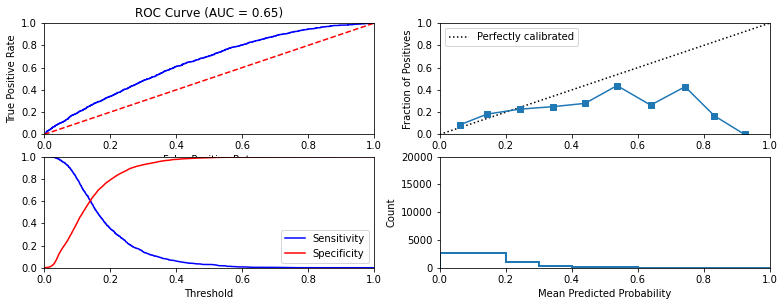


Similarity to LC grade ranking:  0.6291182316368268
Brier score: 0.13315891720000167
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.81005793]


In [ ]:
## Define the time window of your train and test data
import datetime as datetime
start_date_train= pd.Timestamp('2010-01-01 00:00:00')
end_date_train =  pd.Timestamp('2011-01-01 00:00:00')
start_date_test =  pd.Timestamp('2017-01-01 00:00:00')
end_date_test =  pd.Timestamp('2018-01-01 00:00:00')
default_seed = 1

data_dict = prepare_data(date_range_train = (start_date_train, end_date_train), 
                         date_range_test = (start_date_test, end_date_test),
                         feature_subset = your_features, random_state = default_seed)

## Train and test YOURMODEL using this data
l2_logistic_final = l2_logistic['model']
l2_logistic_final = fit_classification(data_dict=data_dict, random_state=default_seed,
                                      model=l2_logistic_final, 
                                      model_name = 'l2_logistic_final',
                                      print_to_screen = True) 

  Model: l2_logistic_final
Fit time: 0.86 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 0.5984122118263427
Accuracy:  0.8365714285714285
              precision    recall  f1-score   support

  No default     0.8395    0.9956    0.9109      5873
     Default     0.2571    0.0080    0.0155      1127

    accuracy                         0.8366      7000
   macro avg     0.5483    0.5018    0.4632      7000
weighted avg     0.7457    0.8366    0.7667      7000



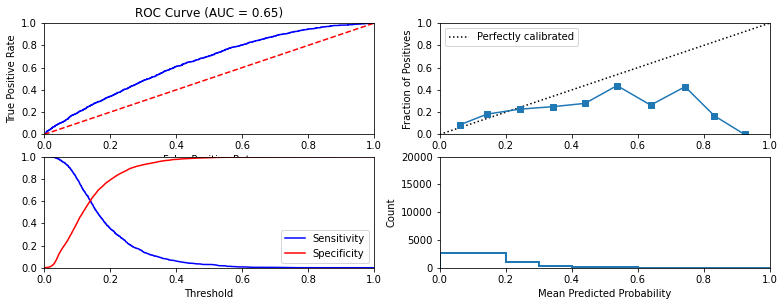


Similarity to LC grade ranking:  0.6291182316368268
Brier score: 0.13315891720000167
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.81005793]


In [ ]:
## Define the time window of your train and test data
start_date_train= pd.Timestamp('2010-01-01 00:00:00')
end_date_train =  pd.Timestamp('2017-01-01 00:00:00')
start_date_test =  pd.Timestamp('2017-01-01 00:00:00')
end_date_test =  pd.Timestamp('2018-01-01 00:00:00')

data_dict_test = prepare_data(date_range_train = (start_date_train, end_date_train), 
                         date_range_test = (start_date_test, end_date_test),
                        feature_subset = your_features)

## Train and test YOURMODEL using this data
l2_logistic_final = l2_logistic['model']
l2_logistic_final = fit_classification(data_dict=data_dict, random_state=default_seed,
                                      model=l2_logistic_final, 
                                      model_name = 'l2_logistic_final',
                                      print_to_screen = True) 

STABLE

## 6. Train and test YOURMODEL on the original data

In [ ]:
# A helper function that you'll be using while reading the raw files
def is_integer(x):
    '''
    This function returns True if x is an integer, and False otherwise
    '''
    try:
        return (int(x) == float(x))
    except:
        return False

In [ ]:
def ingest_files(directory):
    '''
    This function will ingest every file in the specified directory
    into a pandas dataframe. It will return a dictionary containing
    these dataframes, keyed by the file name.
    
    We assume the directory contains files directly downloaded from
    the link given in the handout, and *only* those files. Thus, we 
    assume the files are zipped (pd.read_csv can read zipped files) 
    and we assume the first line in each file needs to be skipped.
    
    Note that each file will be read *without* formatting
    '''
    
    # If the directory has no trailing slash, add one
    if directory[-1] != "/":
        directory = directory+'/'
    
    all_files = os.listdir(directory) # get list of all files from the directory
    output = {}
    
    print("Directory " + directory + " has " + str(len(all_files)) + " files:")
    for i in all_files:
        print("    Reading file " + i)
        output[i] = pd.read_csv(directory+i, dtype='str', skiprows=1) # read each with dtype='str' and skip_rows =1
        
        # Some of the files have "summary" lines that, for example
        # read "Total number of loans number in Policy 1: ....."
        # To remove those lines, find any lines with non-integer IDs
        # and remove them
        invalid_rows = output[i]['id'].apply(lambda x: not is_integer(x)) # mask rows that have non-integer IDs. Use is_integer method
        if invalid_rows.sum() > 0:
            print("Found " + str(invalid_rows.sum()) + " invalid rows which were removed")
            output[i] = output[i].drop(output[i].index[invalid_rows]) # remove invalid rows
    
    
    return output # return dictionary of dataframe

In [ ]:
dir_cs = r'E:\95828 Machine Learning for Problem Solving\Homework\Case Study\Phase 2\2003_download'
files_cs = ingest_files(dir_cs)

Directory E:\95828 Machine Learning for Problem Solving\Homework\Case Study\Phase 2\2003_download/ has 20 files:
    Reading file LoanStats3a_securev1.csv.zip
Found 3 invalid rows which were removed
    Reading file LoanStats3b_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats3c_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats3d_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q2.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q3.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q4.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2017Q1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2017Q2.csv.zip
Found 2 invalid rows which were remov

In [ ]:
data_cs = pd.concat(files_cs.values()).reset_index(drop = True) # combine "files_cs" into a pandas dataframe
                                                                # resent index with drop = True

In [ ]:
feature_subset = ['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
        'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership',
        'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'title',
        'zip_code', 'addr_state', 'dti', 'total_pymnt', 'delinq_2yrs', 'earliest_cr_line',
        'open_acc', 'pub_rec', 'last_pymnt_d', 'last_pymnt_amnt', 'fico_range_high',
        'fico_range_low', 'last_fico_range_high', 'last_fico_range_low',
        'application_type', 'revol_bal', 'revol_util', 'recoveries']


cols_to_pick = ['id', 'loan_amnt', 'funded_amnt', 'term', 'int_rate', 
                'grade', 'emp_length', 'home_ownership',
                'annual_inc', 'verification_status', 'issue_d', 
                'loan_status', 'purpose', 'dti', 'delinq_2yrs', 
                'earliest_cr_line', 'open_acc', 'pub_rec', 
                'fico_range_high', 'fico_range_low', 'revol_bal', 'revol_util', 
                'total_pymnt', 'recoveries', 'last_pymnt_d']

In [ ]:
data = data_cs.loc[:, feature_subset]

In [ ]:
# Identify the type of each of these column based on your CS-Phase 1 response
float_cols = ['loan_amnt', 'funded_amnt', 'annual_inc', 'dti', 
              'delinq_2yrs', 'open_acc', 'pub_rec', 'fico_range_high', 'fico_range_low',
              'revol_bal', 'total_pymnt', 'recoveries']
cat_cols = ['term','grade','emp_length', 'home_ownership', 'verification_status',
             'loan_status', 'purpose'] # categorical features
perc_cols = ['int_rate', 'revol_util']
date_cols = ['issue_d', 'earliest_cr_line', 'last_pymnt_d']

In [ ]:
for i in float_cols:
    data[i] = data[i].astype('float')

def clean_perc(x):
    if pd.isnull(x):
        return np.nan
    else:
        return float(x.strip()[:-1])

for i in perc_cols:
    data[i] = data[i].apply(lambda x: clean_perc(x))

In [ ]:
def clean_date(x):
    if pd.isnull(x):
        return None
    else:
        return datetime.datetime.strptime(x, "%b-%Y").date()

for i in date_cols:
    data[i] = data[i].apply(lambda x: clean_date(x))

def clean_cat(x):
    if not x:
        return None
    else:
        return x

for i in cat_cols:
    data[i] = data[i].apply(lambda x: clean_cat(x))

In [ ]:
# Remove all loans that are still current
n_rows = len(data)

data = data[(data['loan_status'] == 'Charged Off') | (data['loan_status'] == 'Fully Paid') | (data['loan_status'] == 'Default')]

print("Removed " + str(n_rows - len(data)) + " rows")

Removed 1625235 rows


In [ ]:
# Only include loans isssued since 2010
n_rows = len(data)

data = data[(data['issue_d'] > datetime.date(2010,1,1))]

print("Removed " + str(n_rows - len(data)) + " rows")

Removed 7118 rows


In [ ]:
data = data[data['loan_status'].isin(['Fully Paid', 'Charged Off', 'Default'])]
req_cols = set(cols_to_pick) - set(cat_cols) - set(['id'])
req_cols.add('grade')
data = data.dropna(subset = req_cols)

# Deal with null values. We allow cateogrical variables to be null
# OTHER than grade, which is a particularly important categorical.
# All non-categorical variables must be non-null, and we drop
# rows that do not meet this requirement

required_cols = set(cols_to_pick) - set(cat_cols) - set(["id"])
required_cols.add("grade")

n_rows = len(data)

# drop rows that contain null based only on "required_cols"

data = data.dropna(subset=required_cols)

print("Removed " + str(n_rows - len(data)) + " rows")

Removed 0 rows


In [ ]:
discrete_features_og = list(set(cat_cols) - set(["loan_status"]))

# All numeric columns will be used as continuous features
continuous_features_og = list(float_cols + perc_cols)

In [ ]:
data["outcome"] = [True if x in ["Charged Off", "Default"] else False for x in data["loan_status"]]

data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features_og.append('cr_hist')

np.random.seed(default_seed)
data['train'] = np.random.choice(a=[True, False], size=len(data), p=[0.7, 0.3])

X_continuous = data[continuous_features_og].values

X_discrete = pd.get_dummies(data[discrete_features_og], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies_og = X_discrete.columns.tolist()
X_discrete = X_discrete.values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

y = data.outcome.values

train = data.train.values

In [ ]:
def prepare_data_og(data_subset = np.array([True]*len(data)),
                    n_samples_train = 8500,
                    n_samples_test = 7000,
                    feature_subset = None,
                    date_range_train = (data.issue_d.min(), data.issue_d.max()),
                    date_range_test = (data.issue_d.min(), data.issue_d.max()),
                    random_state = default_seed):
    '''
    This function will prepare the data for classification or regression.
    It expects the following parameters:
      - data_subset: a numpy array with as many entries as rows in the
                     dataset. Each entry should be True if that row
                     should be used, or False if it should be ignored
      - n_samples_train: the total number of samples to be used for training.
                         Will trigger an error if this number is larger than
                         the number of rows available after all filters have
                         been applied
      - n_samples_test: as above for testing
      - feature_subect: A list containing the names of the features to be
                        used in the model. In None, all features in X are
                        used
      - date_range_train: a tuple containing two dates. All rows with loans
                          issued outside of these two dates will be ignored in
                          training
      - date_range_test: as above for testing
      - random_state: the random seed to use when selecting a subset of rows
      
    Note that this function assumes the data has a "Train" column, and will
    select all training rows from the rows with "True" in that column, and all
    the testing rows from those with a "False" in that column.
    
    This function returns a dictionary with the following entries
      - X_train: the matrix of training data
      - y_train: the array of training labels
      - train_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the train set
      - X_test: the matrix of testing data
      - y_test: the array of testing labels
      - test_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the test set
    '''
    
    np.random.seed(random_state)
        
    # Filter down the data to the required date range, and downsample
    # as required
    filter_train = ( train & (data.issue_d >= date_range_train[0]) &
                            (data.issue_d <= date_range_train[1]) & data_subset ).values
    filter_test = ( (train == False) & (data.issue_d >= date_range_test[0])
                            & (data.issue_d <= date_range_test[1]) & data_subset ).values


    filter_train[ np.random.choice( np.where(filter_train)[0], size = filter_train.sum()
                                                   - n_samples_train, replace = False ) ] = False
    filter_test[ np.random.choice( np.where(filter_test)[0], size = filter_test.sum()
                                                   - n_samples_test, replace = False ) ] = False
    
    # Prepare the training and test set
    X_train = X[ filter_train , :]
    X_test = X[ filter_test, :]
    if feature_subset != None:
        cols = [i for i, j in enumerate(continuous_features_og + discrete_features_dummies_og)
                                                     if j.split("::")[0] in feature_subset]
        X_train = X_train[ : , cols ]
        X_test = X_test[ : , cols ]
        
    y_train = y[ filter_train ]
    y_test = y[ filter_test ]
    
    # Scale the variables
    scaler = preprocessing.MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # return training and testing data
    out = {'X_train':X_train, 'y_train':y_train, 'train_set':filter_train, 
           'X_test':X_test, 'y_test':y_test, 'test_set':filter_test}
    
    return out

In [ ]:
data_dict_og = prepare_data_og(feature_subset = feature_subset)

  Model: Original Data L2 Logistic
Fit time: 3.21 seconds
Optimal parameters:
{'C': 1000}

Accuracy-maximizing threshold was: 0.2417155994420286
Accuracy:  0.9918571428571429
              precision    recall  f1-score   support

  No default     0.9918    0.9980    0.9949      5568
     Default     0.9921    0.9679    0.9799      1432

    accuracy                         0.9919      7000
   macro avg     0.9920    0.9830    0.9874      7000
weighted avg     0.9919    0.9919    0.9918      7000



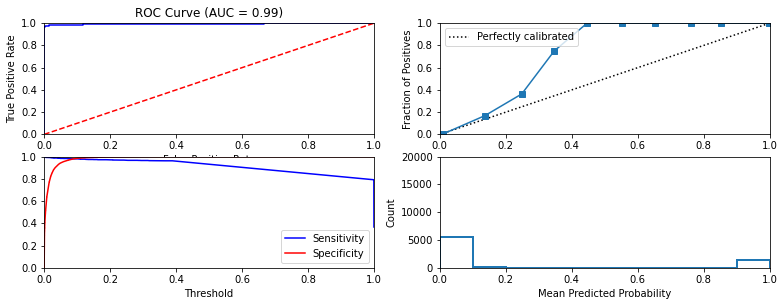


Similarity to LC grade ranking:  0.08977861837638146
Brier score: 0.008092583406357925
Were parameters on edge? : True
Score variations around CV search grid : 28.547035674355147
[0.98702845 0.98356625 0.97469055 0.94892809 0.88497188 0.70526109]


In [ ]:
l2_logistic = LogisticRegression(penalty='l2', solver='lbfgs')
cv_parameters = {'C':[1000, 100, 10, 1, .1, .001]}

l2_logistic = fit_classification(l2_logistic,data_dict_og,
                                cv_parameters=cv_parameters, output_to_file = True,
                                model_name="Original Data L2 Logistic",
                                random_state=default_seed)

# 3.2. Investment Strategies

## 7. Test regression models

In [ ]:
def fit_regression(model, data_dict,
                      cv_parameters = {},
                      separate = False, 
                      model_name = None,
                      random_state = default_seed,
                      output_to_file = True,
                      print_to_screen = True):
    '''
    This function will fit a regression model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - separate: a Boolean variable indicating whether we fit models for 
                  defaulted and non-defaulted loans separately
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over      
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    This function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - model: the best fitted model
      - predicted_return: prediction result based on the test set
      - predicted_regular_return: prediction result for non-defaulted loans (valid if separate == True)
      - predicted_default_return: prediction result for defaulted loans (valid if separate == True)
      - r2_scores: the testing r2_score(s) for the best fitted model
    '''
    
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    X_train = data_dict['X_train']
    filter_train = data_dict['train_set']  

    X_test = data_dict['X_test']
    filter_test = data_dict['test_set']
    out = {}
    
    for ret_col in col_list:
        
        y_train = data.loc[filter_train, ret_col].to_numpy()
        y_test = data.loc[filter_test, ret_col].to_numpy()

        # --------------------------
        #   Step 2 - Fit the model
        # --------------------------

        if separate:
            outcome_train = data.loc[filter_train, 'outcome']
            outcome_test = data.loc[filter_test, 'outcome']

            # Train two separate regressors for defaulted and non-defaulted loans
            X_train_0 = X_train[outcome_train == False]
            y_train_0 = y_train[outcome_train == False]
            X_test_0 = X_test[outcome_test == False]
            y_test_0 = y_test[outcome_test == False]

            X_train_1 = X_train[outcome_train == True]
            y_train_1 = y_train[outcome_train == True]
            X_test_1 = X_test[outcome_test == True]
            y_test_1 = y_test[outcome_test == True]

            cv_model_0 = GridSearchCV(model, cv_parameters, scoring='r2')
            cv_model_1 = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model_0.fit(X_train_0, y_train_0)
            cv_model_1.fit(X_train_1, y_train_1)
            end_time = time.time()

            best_model_0 = cv_model_0.best_estimator_
            best_model_1 = cv_model_1.best_estimator_
            
            if print_to_screen:

                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print("model_0:",cv_model_0.best_params_, "model_1",cv_model_1.best_params_)

            predicted_regular_return = best_model_0.predict(X_test)
            predicted_default_return = best_model_1.predict(X_test)
            
            if print_to_screen:
                print("")
                print("Testing r2 scores:")
            # Here we use different testing set to report the performance
            test_scores = {'model_0':r2_score(y_test_0,best_model_0.predict(X_test_0)),
                              'model_1':r2_score(y_test_1,best_model_1.predict(X_test_1))}
            if print_to_screen:
                print("model_0:", test_scores['model_0'])
                print("model_1:", test_scores['model_1'])

            cv_objects = {'model_0':cv_model_0, 'model_1':cv_model_1}
            out[ret_col] = { 'model_0':best_model_0, 'model_1':best_model_1, 'predicted_regular_return':predicted_regular_return,
                      'predicted_default_return':predicted_default_return,'r2_scores':test_scores }

        else:
            cv_model = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model.fit(X_train, y_train)
            end_time = time.time()

            best_model = cv_model.best_estimator_
            
            if print_to_screen:
                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print(cv_model.best_params_)

            predicted_return = best_model.predict(X_test)
            test_scores = {'model':r2_score(y_test,predicted_return)}
            if print_to_screen:
                print("")
                print("Testing r2 score:", test_scores['model'])

            cv_objects = {'model':cv_model}
            out[ret_col] = {'model':best_model, 'predicted_return':predicted_return, 'r2_scores':r2_score(y_test,predicted_return)}

        # Output the results to a file
        if output_to_file:
            for i in cv_objects:
                # Check whether any of the CV parameters are on the edge of
                # the search space
                opt_params_on_edge = find_opt_params_on_edge(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::search_on_edge", opt_params_on_edge)
                if print_to_screen:
                    print("Were parameters on edge (" + i + ") : " + str(opt_params_on_edge))

                # Find out how different the scores are for the different values
                # tested for by cross-validation. If they're not too different, then
                # even if the parameters are off the edge of the search grid, we should
                # be ok
                score_variation = find_score_variation(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::score_variation", score_variation)
                if print_to_screen:
                    print("Score variations around CV search grid (" + i + ") : " + str(score_variation))

                # Print out all the scores
                dump_to_output(model_name + "::all_cv_scores", str(cv_objects[i].cv_results_['mean_test_score']))
                if print_to_screen:
                    print("All test scores : " + str(cv_objects[i].cv_results_['mean_test_score']) )

                # Dump the AUC to file
                dump_to_output( model_name + "::" + ret_col + "::r2", test_scores[i] )

    return out

### $l_1$ regularized linear regression

In [ ]:
from sklearn.linear_model import Lasso
## First, trying l1 regularized linear regression with hyper-parameters

reg_lasso = Lasso()

cv_parameters = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10,100,1000]}

reg_lasso = fit_regression(model = reg_lasso, 
                      data_dict = data_dict,
                      cv_parameters = cv_parameters,
                      separate = False, 
                      model_name = "Linear Regression with L1 regularization - all returns",
                      random_state = default_seed,
                      output_to_file = True,
                      print_to_screen = True)

  Model: Linear Regression with L1 regularization - all returns  Return column: ret_PESS
Fit time: 6.21 seconds
Optimal parameters:
{'alpha': 0.0001}

Testing r2 score: 0.019358095456248225
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -20.25150392884122
All test scores : [-0.09743679 -0.10511802 -0.1171692  -0.1171692  -0.1171692  -0.1171692
 -0.1171692  -0.1171692 ]
  Model: Linear Regression with L1 regularization - all returns  Return column: ret_OPT
Fit time: 2.28 seconds
Optimal parameters:
{'alpha': 0.001}

Testing r2 score: 0.005676798772829894
Were parameters on edge (model) : False
Score variations around CV search grid (model) : -85.97312453623837
All test scores : [-0.00664668 -0.00603085 -0.01121575 -0.01121575 -0.01121575 -0.01121575
 -0.01121575 -0.01121575]
  Model: Linear Regression with L1 regularization - all returns  Return column: ret_INTa
Fit time: 6.56 seconds
Optimal parameters:
{'alpha': 0.001}

Testing r2 score: 0.0220

In [ ]:
cv_parameters = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10,100,1000]}
reg_lasso = Lasso()
reg_lasso_sep = fit_regression(model = reg_lasso, 
                      data_dict = data_dict,
                      cv_parameters = cv_parameters,
                      separate = True, 
                      model_name = "Linear Regression with L1 regularization - separated returns",
                      output_to_file = True,
                      print_to_screen = True)

  Model: Linear Regression with L1 regularization - separated returns  Return column: ret_PESS
Fit time: 5.49 seconds
Optimal parameters:
model_0: {'alpha': 0.0001} model_1 {'alpha': 0.0001}

Testing r2 scores:
model_0: 0.15399752374351583
model_1: 0.14069705278474942
Were parameters on edge (model_0) : True
Score variations around CV search grid (model_0) : -67.7410816812658
All test scores : [-0.35433842 -0.47740721 -0.59437111 -0.59437111 -0.59437111 -0.59437111
 -0.59437111 -0.59437111]
Were parameters on edge (model_1) : True
Score variations around CV search grid (model_1) : -69.34768762515101
All test scores : [-0.28427361 -0.30511625 -0.42632606 -0.48141079 -0.48141079 -0.48141079
 -0.48141079 -0.48141079]
  Model: Linear Regression with L1 regularization - separated returns  Return column: ret_OPT
Fit time: 6.39 seconds
Optimal parameters:
model_0: {'alpha': 0.0001} model_1 {'alpha': 0.0001}

Testing r2 scores:
model_0: 0.29949826634098764
model_1: 0.1241207703918773
Were para

### $l_2$ regularized linear regressor

In [ ]:
from sklearn.linear_model import Ridge

In [ ]:
## trying l2 regularized linear regression with hyper-parameters

ridge = Ridge()

cv_parameters = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10,100,1000]}

reg_ridge = fit_regression(model = ridge, 
                      data_dict = data_dict,
                      cv_parameters = cv_parameters,
                      separate = False, 
                      model_name = "Linear Regression with L2 regularization",
                      random_state = default_seed,
                      output_to_file = True,
                      print_to_screen = True)

  Model: Linear Regression with L2 regularization  Return column: ret_PESS
Fit time: 1.62 seconds
Optimal parameters:
{'alpha': 1}

Testing r2 score: 0.026116338166243702
Were parameters on edge (model) : False
Score variations around CV search grid (model) : -4.520129773102114
All test scores : [-0.09555287 -0.09554792 -0.09552097 -0.09528726 -0.09446276 -0.09582116
 -0.09672208 -0.0987326 ]
  Model: Linear Regression with L2 regularization  Return column: ret_OPT
Fit time: 1.26 seconds
Optimal parameters:
{'alpha': 1000}

Testing r2 score: 0.01020672597450345
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -39.10616910591692
All test scores : [-0.00778206 -0.00777858 -0.00776325 -0.00762792 -0.00704564 -0.00738279
 -0.00725273 -0.00559433]
  Model: Linear Regression with L2 regularization  Return column: ret_INTa
Fit time: 1.52 seconds
Optimal parameters:
{'alpha': 1000}

Testing r2 score: 0.024540449781310425
Were parameters on edge (model) : 

In [ ]:
ridge = Ridge()

cv_parameters = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10,100,1000]}

reg_ridge_sep = fit_regression(model = ridge, 
                      data_dict = data_dict,
                      cv_parameters = cv_parameters,
                      separate = True, 
                      model_name = "Linear Regression with L2 regularization - Separated Returns",
                      random_state = default_seed,
                      output_to_file = True,
                      print_to_screen = True)

  Model: Linear Regression with L2 regularization - Separated Returns  Return column: ret_PESS
Fit time: 1.4 seconds
Optimal parameters:
model_0: {'alpha': 10} model_1 {'alpha': 0.0001}

Testing r2 scores:
model_0: 0.16508906967048265
model_1: 0.13800270014202554
Were parameters on edge (model_0) : False
Score variations around CV search grid (model_0) : -12.636574621457076
All test scores : [-0.35811285 -0.35817301 -0.35807021 -0.35704783 -0.35232236 -0.35150882
 -0.35601522 -0.3959275 ]
Were parameters on edge (model_1) : True
Score variations around CV search grid (model_1) : -23.665511277401116
All test scores : [-0.27266947 -0.27267322 -0.27272728 -0.27394115 -0.28046502 -0.28332977
 -0.28628511 -0.3371981 ]
  Model: Linear Regression with L2 regularization - Separated Returns  Return column: ret_OPT
Fit time: 1.5 seconds
Optimal parameters:
model_0: {'alpha': 1} model_1 {'alpha': 0.0001}

Testing r2 scores:
model_0: 0.31077831392455313
model_1: 0.12182929524077357
Were parameters

### Multi-layer perceptron regressor

In [ ]:
## trying multi-layer perceptron regression with hyper-parameters

mlp_regressor = MLPRegressor()
cv_parameters = {'solver':['sgd', 'adam'],
                 'activation':['logistic', 'tanh', 'relu'],
                 'learning_rate':['constant', 'adaptive'],
                 'hidden_layer_sizes':(5,2)}

mlp_reg = fit_regression(mlp_regressor, data_dict = data_dict, 
                         cv_parameters = cv_parameters, separate=False,
                         model_name = "MLP regressor - all returns", 
                         print_to_screen = True, output_to_file = True)

  Model: MLP regressor - all returns  Return column: ret_PESS
Fit time: 176.88 seconds
Optimal parameters:
{'activation': 'logistic', 'hidden_layer_sizes': 2, 'learning_rate': 'constant', 'solver': 'adam'}

Testing r2 score: 0.02387736119461381
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -387.3252681913563
All test scores : [-0.18054995 -0.11002398 -0.1971376  -0.11391167 -0.19504897 -0.10513114
 -0.16938177 -0.125063   -0.51233063 -0.1681544  -0.43909049 -0.11664206
 -0.35714028 -0.18219333 -0.35595095 -0.20775523 -0.36639185 -0.12194518
 -0.31557063 -0.12411923 -0.26439361 -0.27528402 -0.18099956 -0.12717248]
  Model: MLP regressor - all returns  Return column: ret_OPT
Fit time: 175.8 seconds
Optimal parameters:
{'activation': 'logistic', 'hidden_layer_sizes': 2, 'learning_rate': 'constant', 'solver': 'adam'}

Testing r2 score: 0.008046229120330595
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -3300

In [ ]:
## trying multi-layer perceptron regression with hyper-parameters

mlp_regressor = MLPRegressor()
cv_parameters = {'solver':['sgd', 'adam'],
                 'activation':['logistic', 'tanh', 'relu'],
                 'learning_rate':['constant', 'adaptive'],
                 'hidden_layer_sizes':(5,2)}

mlp_reg_sep = fit_regression(mlp_regressor, data_dict = data_dict, 
                         cv_parameters = cv_parameters, separate=True,
                         model_name = "MLP regressor - separated returns", 
                         print_to_screen = True, output_to_file = True)

  Model: MLP regressor - separated returns  Return column: ret_PESS
Fit time: 207.29 seconds
Optimal parameters:
model_0: {'activation': 'logistic', 'hidden_layer_sizes': 5, 'learning_rate': 'adaptive', 'solver': 'adam'} model_1 {'activation': 'relu', 'hidden_layer_sizes': 5, 'learning_rate': 'constant', 'solver': 'adam'}

Testing r2 scores:
model_0: 0.15041692264389184
model_1: -0.005342627260451316
Were parameters on edge (model_0) : True
Score variations around CV search grid (model_0) : -1049.9627713669722
All test scores : [-2.73010141 -0.6044044  -2.11776907 -0.48503734 -1.57648617 -0.63824222
 -1.32303257 -0.89499589 -5.57774881 -1.06895199 -4.83802217 -1.22707457
 -5.19063357 -1.3410899  -4.3696662  -2.35324935 -3.98616523 -1.10621127
 -2.99008016 -1.98583747 -4.70365824 -2.79438132 -1.41804236 -1.34475012]
Were parameters on edge (model_1) : True
Score variations around CV search grid (model_1) : -452.95760117127764
All test scores : [-0.63176751 -0.46999831 -0.62957916 -0.456

### Random forest regressor

In [ ]:
## trying random forest regression with hyper-parameters

random_forest_regressor = RandomForestRegressor()
cv_parameters = {'n_estimators':[10, 20,30,40],
                'max_depth':[1,2,3,4]}

reg_rf = fit_regression(random_forest_regressor, data_dict = data_dict,
                       cv_parameters = cv_parameters, separate=False,
                       model_name = "Random Forest regression", 
                       print_to_screen = True, output_to_file = True)

  Model: Random Forest regression  Return column: ret_PESS
Fit time: 79.65 seconds
Optimal parameters:
{'max_depth': 4, 'n_estimators': 30}

Testing r2 score: 0.018329922877681537
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -16.287615698547775
All test scores : [-0.11008295 -0.10777903 -0.10752536 -0.10796219 -0.09982607 -0.10040845
 -0.1008492  -0.09970248 -0.09609208 -0.09812443 -0.09844466 -0.0968839
 -0.09783774 -0.09550288 -0.09466438 -0.09505625]
  Model: Random Forest regression  Return column: ret_OPT
Fit time: 78.97 seconds
Optimal parameters:
{'max_depth': 4, 'n_estimators': 30}

Testing r2 score: 0.012699942165772526
Were parameters on edge (model) : True
Score variations around CV search grid (model) : 1037.5993390320562
All test scores : [-6.61233368e-03 -6.66331126e-03 -6.86852513e-03 -6.75163006e-03
 -9.16209983e-04 -8.88193670e-04 -8.61314488e-04 -9.21985675e-04
 -3.02294572e-05  8.11322100e-06  2.79087132e-04 -2.31173001e-04


In [ ]:
## trying random forest regression with hyper-parameters

random_forest_regressor = RandomForestRegressor()
cv_parameters = {'n_estimators':[10, 20,30,40],
                'max_depth':[1,2,3,4]}

reg_rf_sep = fit_regression(random_forest_regressor, data_dict = data_dict,
                       cv_parameters = cv_parameters, separate=True,
                       model_name = "Random Forest regression", 
                       print_to_screen = True, output_to_file = True)

  Model: Random Forest regression  Return column: ret_PESS
Fit time: 80.83 seconds
Optimal parameters:
model_0: {'max_depth': 4, 'n_estimators': 40} model_1 {'max_depth': 4, 'n_estimators': 20}

Testing r2 scores:
model_0: 0.15400530220977193
model_1: 0.14281657923895463
Were parameters on edge (model_0) : True
Score variations around CV search grid (model_0) : -35.00324658275907
All test scores : [-0.46119086 -0.45240583 -0.46024897 -0.45844475 -0.38973121 -0.38984096
 -0.38717715 -0.38926346 -0.35077217 -0.35252555 -0.35184228 -0.35158138
 -0.34814402 -0.34296134 -0.34292997 -0.34161464]
Were parameters on edge (model_1) : True
Score variations around CV search grid (model_1) : -11.812634732312146
All test scores : [-0.30302632 -0.30610868 -0.30123215 -0.31000067 -0.30210651 -0.29452722
 -0.2899631  -0.29226264 -0.28863338 -0.28508046 -0.28658116 -0.28423067
 -0.29024303 -0.27725012 -0.28290177 -0.28333997]
  Model: Random Forest regression  Return column: ret_OPT
Fit time: 80.9 seco

## Test investment strategies 
Now we test several investment strategies using the learning models above

In [ ]:
def average_return(returns ,amount):
    avg_return = np.dot(returns, amount)
    return avg_return/np.sum(amount)

In [ ]:
def test_investments(data_dict,
                     classifier = None,
                     regressor = None,
                     strategy = 'Random', 
                     num_loans = 1000,
                     random_state = default_seed,
                     output_to_file = True):
    '''
    This function tests a variety of investment methodologies and their returns. 
    It will run its tests on the loans defined by the test_set element of the data
    dictionary.
    
    It is currently able to test four strategies
      - random: invest in a random set of loans
      - default-based: score each loan by probability of default, and only invest
                 in the "safest" loans (i.e., those with the lowest probabilities
                 of default)
      - return-based: train a single regression model to predict the expected return
                    of loans in the past. Then, for loans we could invest in, simply
                    rank them by their expected returns and invest in that order.
      - default-& return-based: train two regression models to predict the expected return of
                   defaulted loans and non-defaulted loans in the training set. Then,
                   for each potential loan we could invest in, predict the probability
                   the loan will default, its return if it doesn't default and its
                   return if it does. Then, calculate a weighted combination of
                   the latter using the former to find a predicted return. Rank the
                   loans by this expected return, and invest in that order
    
    It expects the following parameters
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - classifier: a fitted model object which is returned by the fit_classification function.
      - regressor: a fitted model object which is returned by the fit_regression function.
      - strategy: the name of the strategy; one of the three listed above
      - num_loans: the number of loans to be included in the test portfolio
      - num_samples: the number of random samples used to compute average return ()   
      - random_state: the random seed to use when selecting a subset of rows
      - output_to_file: if the results will be saved to the output file
      
    The function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - strategy: the name of the strategy
      - average return: the return of the strategy based on the testing set
      - test data: the updated Dataframe of testing data. Useful in the optimization section
    '''
    
    np.random.seed(random_state)
    
    # Retrieve the rows that were used to train and test  the
    # classification model
    train_set = data_dict['train_set']
    test_set = data_dict['test_set']
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    # Create a dataframe for testing, including the score
    data_test = data.loc[test_set,:]
    out = {}
    
    for ret_col in col_list:    
    
        if strategy == 'Random':
            # Randomize the order of the rows in the datframe
            data_test = data_test.sample(frac = 1).reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = data_test[['funded_amnt',ret_col]].iloc[:num_loans]

            ## Find the average return for these loans
            ret_test = average_return(pf_test[ret_col], pf_test['funded_amnt'])

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test,'test data':pf_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
        
        elif strategy == 'Return-based':
            
            colname = 'predicted_return_' + ret_col 

            data_test[colname] = regressor[ret_col]['predicted_return']

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans
            pf_test = data_test[['funded_amnt',ret_col]].iloc[:num_loans]

            ## Find their return
            ret_test = average_return(pf_test[ret_col], pf_test['funded_amnt'])

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':pf_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
            
        # Get the predicted scores, if the strategy is not Random or just Regression
        try:
            y_pred_score = classifier['y_pred_probs']
        except:
            y_pred_score = classifier['y_pred_score']

        data_test['score'] = y_pred_score


        if strategy == 'Default-based':
            # Sort the test data by the score
            data_test = data_test.sort_values(by='score').reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = data_test[['funded_amnt',ret_col]].iloc[:num_loans]

            ## Find the average return for these loans
            ret_test = average_return(pf_test[ret_col], pf_test['funded_amnt'])

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test,'test data':pf_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue


        elif strategy == 'Default-return-based':

            # Load the predicted returns
            data_test['predicted_regular_return'] = regressor[ret_col]['predicted_regular_return']
            data_test['predicted_default_return'] = regressor[ret_col]['predicted_default_return']

            # Compute expectation
            colname = 'predicted_return_' + ret_col 
            
            data_test[colname] = ( (1-data_test.score)*data_test.predicted_regular_return + 
                                             data_test.score*data_test.predicted_default_return )

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans
            pf_test = data_test[['funded_amnt',ret_col]].iloc[:num_loans]

            ## Find their return
            ret_test = average_return(pf_test[ret_col], pf_test['funded_amnt'])

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':pf_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        else:
            return 'Not a valid strategy'
        
    return out

In [ ]:
master_PESS_list=[]
master_OPT_list=[]
master_INTa_list=[]
master_INTb_list=[]

In [ ]:
## Test investment strategies using the best performing regressor

col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
test_strategy = 'Default-based'

print('strategy:',test_strategy)  
ret_PESS_avg = []
ret_OPT_avg = []
ret_INTa_avg = []
ret_INTb_avg = []

for i in tqdm_notebook(range(1,101,1)):
    default_seed = i
    #np.random.seed(default_seed)
    ## create the train column where the value is True 
    # if it is a train instance and False otherwise. 
    # Hint: use np.random.choice with 70% for training and 30% for testing
      
    #data_dict = prepare_data(feature_subset = your_features_dropped, random_state=default_seed)

    strat_rand = test_investments(data_dict, strategy = test_strategy, 
                                   classifier = l2_logistic,random_state=default_seed)
    ret_PESS_avg.append(strat_rand['ret_PESS']['average return'])
    ret_OPT_avg.append(strat_rand['ret_OPT']['average return'])
    ret_INTa_avg.append(strat_rand['ret_INTa']['average return'])
    ret_INTb_avg.append(strat_rand['ret_INTb']['average return'])

master_PESS_list=master_PESS_list+list(strat_rand["ret_PESS"]["test data"]["ret_PESS"])
master_OPT_list=master_OPT_list+list(strat_rand["ret_OPT"]["test data"]["ret_OPT"])
master_INTa_list=master_INTa_list+list(strat_rand["ret_INTa"]["test data"]["ret_INTa"])
master_INTb_list=master_INTb_list+list(strat_rand["ret_INTb"]["test data"]["ret_INTb"])

print('ret_PESS: ' + str(np.mean(ret_PESS_avg)))
print('ret_OPT: ' + str(np.mean(ret_OPT_avg)))
print('ret_INTa: ' + str(np.mean(ret_INTa_avg)))
print('ret_INTb: ' + str(np.mean(ret_INTb_avg)))


# for ret_col in col_list:
#     print(ret_col + ': ' + str(strat_rand[ret_col]['average return']))

strategy: Default-based


  0%|          | 0/100 [00:00<?, ?it/s]

ret_PESS: 0.016783134149769514
ret_OPT: 0.045553964639631975
ret_INTa: 0.4288787779929422
ret_INTb: 1.275990962869367


In [ ]:
## Test investment strategies using the best performing regressor

col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
test_strategy = 'Return-based'

print('strategy:',test_strategy)  
ret_PESS_avg = []
ret_OPT_avg = []
ret_INTa_avg = []
ret_INTb_avg = []

for i in tqdm_notebook(range(1,101,1)):
    default_seed = i
    #np.random.seed(default_seed)
    ## create the train column where the value is True 
    # if it is a train instance and False otherwise. 
    # Hint: use np.random.choice with 70% for training and 30% for testing
      
    #data_dict = prepare_data(feature_subset = your_features_dropped, random_state=default_seed)

    strat_rand = test_investments(data_dict, strategy = test_strategy, 
                                   regressor = reg_rf,random_state=default_seed)
    ret_PESS_avg.append(strat_rand['ret_PESS']['average return'])
    ret_OPT_avg.append(strat_rand['ret_OPT']['average return'])
    ret_INTa_avg.append(strat_rand['ret_INTa']['average return'])
    ret_INTb_avg.append(strat_rand['ret_INTb']['average return'])

master_PESS_list=master_PESS_list+list(strat_rand["ret_PESS"]["test data"]["ret_PESS"])
master_OPT_list=master_OPT_list+list(strat_rand["ret_OPT"]["test data"]["ret_OPT"])
master_INTa_list=master_INTa_list+list(strat_rand["ret_INTa"]["test data"]["ret_INTa"])
master_INTb_list=master_INTb_list+list(strat_rand["ret_INTb"]["test data"]["ret_INTb"])

print('ret_PESS: ' + str(np.mean(ret_PESS_avg)))
print('ret_OPT: ' + str(np.mean(ret_OPT_avg)))
print('ret_INTa: ' + str(np.mean(ret_INTa_avg)))
print('ret_INTb: ' + str(np.mean(ret_INTb_avg)))


# for ret_col in col_list:
#     print(ret_col + ': ' + str(strat_rand[ret_col]['average return']))

strategy: Return-based


  0%|          | 0/100 [00:00<?, ?it/s]

ret_PESS: 0.01738609469152099
ret_OPT: 0.04693376165875609
ret_INTa: 0.4168895342525636
ret_INTb: 1.267057011894209


In [ ]:
## Test investment strategies using the best performing regressor

col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
test_strategy = 'Default-return-based'

print('strategy:',test_strategy)  
ret_PESS_avg = []
ret_OPT_avg = []
ret_INTa_avg = []
ret_INTb_avg = []

for i in tqdm_notebook(range(1,101,1)):
    default_seed = i
    #np.random.seed(default_seed)
    ## create the train column where the value is True 
    # if it is a train instance and False otherwise. 
    # Hint: use np.random.choice with 70% for training and 30% for testing
      
    #data_dict = prepare_data(feature_subset = your_features_dropped, random_state=default_seed)

    strat_rand = test_investments(data_dict, strategy = test_strategy, regressor = reg_rf_sep, classifier = l2_logistic,random_state=default_seed)
    ret_PESS_avg.append(strat_rand['ret_PESS']['average return'])
    ret_OPT_avg.append(strat_rand['ret_OPT']['average return'])
    ret_INTa_avg.append(strat_rand['ret_INTa']['average return'])
    ret_INTb_avg.append(strat_rand['ret_INTb']['average return'])

master_PESS_list=master_PESS_list+list(strat_rand["ret_PESS"]["test data"]["ret_PESS"])
master_OPT_list=master_OPT_list+list(strat_rand["ret_OPT"]["test data"]["ret_OPT"])
master_INTa_list=master_INTa_list+list(strat_rand["ret_INTa"]["test data"]["ret_INTa"])
master_INTb_list=master_INTb_list+list(strat_rand["ret_INTb"]["test data"]["ret_INTb"])

print('ret_PESS: ' + str(np.mean(ret_PESS_avg)))
print('ret_OPT: ' + str(np.mean(ret_OPT_avg)))
print('ret_INTa: ' + str(np.mean(ret_INTa_avg)))
print('ret_INTb: ' + str(np.mean(ret_INTb_avg)))


# for ret_col in col_list:
#     print(ret_col + ': ' + str(strat_rand[ret_col]['average return']))

strategy: Default-return-based


  0%|          | 0/100 [00:00<?, ?it/s]

ret_PESS: 0.017857159548729348
ret_OPT: 0.05318023272685402
ret_INTa: 0.4243411832457838
ret_INTb: 1.2866492976994324


In [ ]:
len(master_PESS_list)

4000

In [ ]:
master_PESS_best= np.mean(sorted(master_PESS_list,reverse=True)[:1000])
master_OPT_best= np.mean(sorted(master_OPT_list,reverse=True)[:1000])
master_INTa_best= np.mean(sorted(master_INTa_list,reverse=True)[:1000])
master_INTb_best= np.mean(sorted(master_INTb_list,reverse=True)[:1000])

In [ ]:
print(master_PESS_best*100)
print(master_OPT_best*100)
print(master_INTa_best*100)
print(master_INTb_best*100)

6.405369393568537
16.353495258975965
58.14949964795375
177.7398098994836


## Sensitivity test of portfolio size

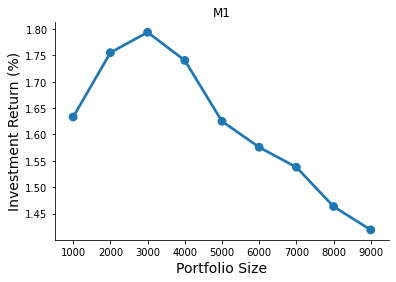

In [ ]:
## Test the best-performing data-driven strategy on different portfolio sizes

result_sensitivity = []

## Vary the portfolio size from 1,000 to 10,000
for num_loans in list(range(1000,10000,1000)):

    reg_0 = test_investments(data_dict, regressor = reg_rf_sep, classifier = l2_logistic, 
                            strategy = 'Default-return-based', num_loans = num_loans)
    result_sensitivity.append(reg_0['ret_PESS']['average return'])
    
result_sensitivity = np.array(result_sensitivity) * 100
sns.pointplot(np.array(list(range(1000,10000,1000))),result_sensitivity)
sns.despine()
plt.ylabel('Investment Return (%)',size = 14)
plt.xlabel('Portfolio Size',size = 14)
plt.title('M1')
plt.show()